<a href="https://colab.research.google.com/github/arangoml/arangopipe/blob/409_and_env_externalization/examples/Arangopipe_Feature_ext2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install python-arango
!pip install -i https://test.pypi.org/simple/ arangopipe
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle

     |████████████████████████████████| 81kB 3.3MB/s 
  Created wheel for python-arango: filename=python_arango-5.2.1-py2.py3-none-any.whl size=86479 sha256=6341aeda2ea862fd577a153127039dc14711a3609011dd617674dad278028b12
  Stored in directory: /root/.cache/pip/wheels/31/30/00/ef5ee59a25096d89fbb9e2526877f74c189eb6db50bbef9474
Successfully built python-arango
Looking in indexes: https://test.pypi.org/simple/
     |████████████████████████████████| 276kB 5.0MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.1.1-cp36-cp36m-linux_x86_64.whl size=44099 sha256=592108373b4f3ec39e5fd01f133f22abb25e00e3d8579ebc511a582ea0a6fab6
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [0]:
import pandas as pd
import numpy as np
data_url = "https://raw.githubusercontent.com/arangoml/arangopipe/arangopipe_examples/examples/data/cal_housing.csv"
df = pd.read_csv(data_url, error_bad_lines=False)
df = df.sample(n = 500)
df.head()

,lat,long,housingMedAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
6291,-117.88,34.00,21,5459,1086,3394,1087,3.6308,192100.0
18877,-122.24,38.07,13,5451,1194,2957,1081,2.6098,162500.0
7198,-118.18,34.03,40,2631,698,2920,677,2.0764,145600.0
15066,-116.96,32.79,17,5236,1325,3308,1233,2.3221,138800.0
2099,-119.76,36.75,35,2347,526,1676,481,1.6548,49400.0


# Detecting Covariate Shift in Datasets¶

Regression models predict a response based on predictor variables. The model parameters are etimated from the data. When the underlying data distribution associated with the predictors changes, the model and its associated parameters that were determined based on a previous batch of data, may not be optimal for the data that we are now seeing. This is known as covariate shift. Ok, so all that is well and good, but how do we detect that the underlying dataset distribution has changed? We can employ a simple technique to do that and we will illustrate that in this notebook.

The problem context is as follows. We have two batches of data. One is the version used to build the current model in production and the other is the batch of data that we have received since the model has been deployed. The question is is the current batch of data different in a distributional sense from the one used to build the current model? We will use machine learning to solve this problem. We will tag the data from the batch used to build the current production model as $0$ and the batch of data that we have received since then as $1$. We will develop a model to discriminate these two labels. If the model we develop can discriminate very well between data from these two batches, then covariate shift has occured and we need to revisit modeling. If the model cannot discriminate well between these two batches, for example, the classifier we develop produces an accuracy of about $0.5$ then this classifier is not very discriminatory. It only performs as well as tossing a fair coin. If we observe such a result, then we conclude that sufficient dataset shift has not occured and our current model will serve us well.

We illustrate this idea with the data from the california housing dataset (available in the UCI machine learning repository). The machine learning task associated with the dataset is to predict the median house value given a set of predictors. The rest of the notebook illustrates the idea discussed above.

In [0]:

req_cols = df.columns.tolist()
req_cols.remove("medianHouseValue")
df = df[req_cols]
df.dtypes

lat              float64
long             float64
housingMedAge      int64
totalRooms         int64
totalBedrooms      int64
population         int64
households         int64
medianIncome     float64
dtype: object

In [0]:
df["lat"].describe()

count    500.000000
mean    -119.546120
std        1.975732
min     -124.160000
25%     -121.642500
50%     -118.525000
75%     -117.990000
max     -115.520000
Name: lat, dtype: float64

##  Exploring the Data

When we plot the histogram of the lat variable, we see two populations (see below):

1. A group with lat values less than -119

2.  A group with lat values greater than -119 

Lets pretend that the current batch of data used to develop our regression model is the first one. We have now received the second batch. Can we discriminate between the two. Lets develop a classifier and see if we can.

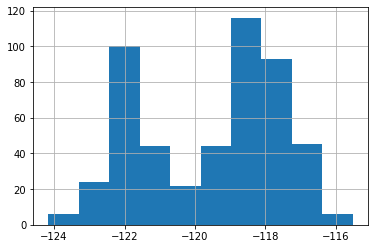

In [0]:

import matplotlib.pyplot as plt
%matplotlib inline  
df["lat"].hist()

In [0]:

df1 = df.query("lat <= -119")
df2 = df.query("lat > -119")

##  Use the dataset shift api

In [0]:
from arangopipe.arangopipe_analytics.rf_dataset_shift_detector import RF_DatasetShiftDetector

rfd = RF_DatasetShiftDetector()
score = rfd.detect_dataset_shift(df1, df2)
print ("Detaset shift score : %2.2f" % (score))

Detaset shift score : 1.00


# Interpretation of the score reported by the shift detecto

The API uses a classifier to discriminate between the datasets provided to it. The score reported by the API is the accuracy of the classifier to discriminate between the datasets. Values close to $0.5$ indicate that the classifier in not able to discriminate between the two datasets. This could be interpretted as a situation where no discernable shift has occured in the data since the last model deployment. Values close $1$ indicate that dataset shift is discernable and that we may need to revisit modeling. How dataset shift affects the performance of the deployed model is problem dependent. So the score must be assessed in the context of a particular application. An experiment to track the loss of model accuracy with the observed score could provide insights into a threshold score beyond which a model redevelopment is needed.